In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import shuffle
from sklearn.ensemble import RandomForestClassifier
import random


def divup(a, b):
    return (a + b - 1) / b

def imshow_bgr(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

In [170]:
def gaus_blur(img, sigma=5, r=25):
    return cv2.GaussianBlur(img, (r, r), sigma)


def prepare_features(img):
    assert img.shape[0] == 512 == img.shape[1]
    sobel_3x = cv2.Sobel(img, cv2.CV_64F, 2, 1, ksize=3)
    sobel_5x = cv2.Sobel(img, cv2.CV_64F, 4, 1, ksize=5)
    sobel_3y = cv2.Sobel(img, cv2.CV_64F, 1, 2, ksize=3)
    sobel_5y = cv2.Sobel(img, cv2.CV_64F, 1, 4, ksize=5)
    
    laplacian = cv2.Laplacian(img.astype(float), cv2.CV_64F)
    
    g3_diff = cv2.absdiff(img, gaus_blur(img, 3, 9))
    g5_diff = cv2.absdiff(img, gaus_blur(img, 5, 11))
    g7_diff = cv2.absdiff(img, gaus_blur(img, 7, 15))
    
    imgx2 = cv2.pyrDown(img)
    imgx4 = cv2.pyrDown(imgx2)
    
    return np.array([
        np.var(img),
        np.var(imgx2),
        np.var(imgx4),
        np.var(sobel_3x),
        np.var(sobel_3y),
        np.var(sobel_5x),
        np.var(sobel_5y),
        np.var(laplacian),
        np.abs(np.sum(sobel_3x)),
        np.abs(np.sum(sobel_3y)),
        np.abs(np.sum(sobel_5x)),
        np.abs(np.sum(sobel_5y)),
        np.abs(np.sum(laplacian)),
        np.var(g3_diff),
        np.var(g5_diff),
        np.var(g7_diff),
    ])

In [167]:
TAKE_FIRST = 150

blurred_imgs = []

for path in glob("blur_detection/CERTH_ImageBlurDataset/TrainingSet/Artificially-Blurred/*")[:TAKE_FIRST]:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512, 512))
    blurred_imgs.append(img)

blurred_imgs = np.stack(blurred_imgs)

sharp_imgs = []

for path in glob("blur_detection/CERTH_ImageBlurDataset/TrainingSet/Undistorted/*")[:TAKE_FIRST]:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512, 512))
    sharp_imgs.append(img)

sharp_imgs = np.stack(sharp_imgs)

print(blurred_imgs.shape)
print(sharp_imgs.shape)

(150, 512, 512)
(150, 512, 512)


In [168]:
X_train = np.concatenate((blurred_imgs, sharp_imgs)).astype(np.float32)[..., np.newaxis] 
y_train = np.zeros((len(X_train), 2))
y_train[:len(blurred_imgs), 0] = 1
y_train[len(blurred_imgs):, 1] = 1

idxs = np.random.permutation(len(X_train))
split = int(0.7 * len(X_train))

X_val = X_train[idxs[split:]]
y_val = y_train[idxs[split:]]

X_train = X_train[idxs[:split]]
y_train = y_train[idxs[:split]]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(210, 512, 512, 1) (210, 2) (90, 512, 512, 1) (90, 2)


In [171]:
train_features = np.array([prepare_features(img) for img in X_train])
val_features = np.array([prepare_features(img) for img in X_val])

print(train_features.shape)
print(val_features.shape)

(210, 16)
(90, 16)


In [173]:
classifier = RandomForestClassifier(max_leaf_nodes=4, n_estimators=10)
classifier.fit(train_features, y_train)

print(classifier.feature_importances_)

[0.         0.         0.         0.28209176 0.0121214  0.24743658
 0.11334855 0.11879698 0.         0.         0.         0.
 0.05919431 0.0709821  0.05529943 0.04072889]


In [174]:
print("Train acc: ", np.sum(np.argmax(classifier.predict(train_features), axis=1) == np.argmax(y_train, axis=1)) / len(y_train))

print("Val acc: ", np.sum(np.argmax(classifier.predict(val_features), axis=1) == np.argmax(y_val, axis=1)) / len(y_val))

Train acc:  0.9904761904761905
Val acc:  1.0


In [188]:
blurred_imgs = []
blurred_paths = []

for path in glob("blur_detection/videos/blurred/*"):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512, 512))
    blurred_imgs.append(img)
    blurred_paths.append(path)


sharp_imgs = []
sharp_paths = []

for path in glob("blur_detection/videos/sharp/*"):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512, 512))
    sharp_imgs.append(img)
    sharp_paths.append(path)
    
print(len(blurred_imgs), len(sharp_imgs))

36 16


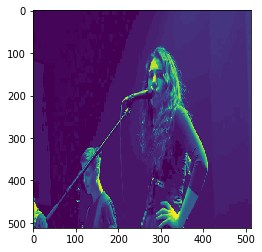

In [189]:
plt.imshow(sharp_imgs[0])
plt.show()

In [181]:
blurred_features = np.array([prepare_features(img) for img in blurred_imgs])
sharp_features = np.array([prepare_features(img) for img in sharp_imgs])

(36, 16)
(16, 16)


## Confusion matrix on "videos"

In [201]:
blurred_prediction = np.argmax(classifier.predict(blurred_features), axis=1)
sharp_prediction = np.argmax(classifier.predict(sharp_features), axis=1)

TP = np.sum(blurred_prediction == 0)
FN = np.sum(blurred_prediction == 1)
FP = np.sum(sharp_prediction == 0)
TN = np.sum(sharp_prediction == 1)

print(np.array([[TP, TN], [FP, FN]]))

print("False negatives")
for i, path in enumerate(blurred_paths):
    if blurred_prediction[i] == 1:
        print(path)
        
print("False positives")
for i, path in enumerate(sharp_paths):
    if sharp_prediction[i] == 0:
        print(path)

[[23 13]
 [ 3 13]]
False negatives
blur_detection/videos/blurred/frame00057.png
blur_detection/videos/blurred/frame00120.png
blur_detection/videos/blurred/frame00142.png
blur_detection/videos/blurred/frame00294.png
blur_detection/videos/blurred/frame00062_2.png
blur_detection/videos/blurred/frame00264.png
blur_detection/videos/blurred/frame00015.png
blur_detection/videos/blurred/frame00023.png
blur_detection/videos/blurred/frame00168.png
blur_detection/videos/blurred/frame00003.png
blur_detection/videos/blurred/frame00096.png
blur_detection/videos/blurred/frame00037.png
blur_detection/videos/blurred/frame00105.png
False positives
blur_detection/videos/sharp/frame00073.png
blur_detection/videos/sharp/frame00009.png
blur_detection/videos/sharp/frame00036.png


## Timings

Due to the fact that the amount of work per image is nearly constant, we may predict on the same set of images multiple times, to get the timings

In [204]:
import time

timings = []
for i in range(20):
    start = time.time()
    [prepare_features(img) for img in blurred_imgs[:10]]
    elapsed = time.time() - start
    timings.append(elapsed)
    
timings = np.array(timings)
print("Feature calculation: ", np.mean(timings) / 10, np.std(timings))

timings = []
for i in range(20):
    start = time.time()
    classifier.predict(blurred_features[:10])
    elapsed = time.time() - start
    timings.append(elapsed)
    
timings = np.array(timings)
print("Prediction: mean ", np.mean(timings) / 10, " sd ", np.std(timings))

Feature calculation:  0.028371703624725342 0.004826986938245036


Prediction: mean  0.008383724689483642  sd  0.3569995856598408
